# Fine-tune LayoutLMv3 for token classification on Arabic Books dataset

## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [1]:
!pip install -q datasets seqeval transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


Let's login to the Hugging Face hub, so we have a place to push our final tuned model.
To create a Hugging Face account if you do not already have one, by visiting https://huggingface.co/ and clicking "Sign Up".  You will then go to your account, look under profile settings, and then select/create an access token with write privileges.  

In [1]:
from huggingface_hub import notebook_login
notebook_login()

Verify you are correctly logged in

In [2]:
!huggingface-cli whoami

alansary


## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/alansary/arabic-books-layoutlm-formatted). This one is the [Arabic Books LayoutLM Formatted](https://huggingface.co/datasets/alansary/arabic-books-layoutlm-formatted) dataset, a collection of annotated Arabic books.

In [3]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("alansary/arabic-books-layoutlm-formatted")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


As we can see, the dataset consists of 3 splits ("train",  "validation", and "test"), and each example contains a list of words ("words") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 672
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 84
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 84
    })
})

Let's check the features. The CORD dataset has a lot!  For a simpler document, check out the FUNSD dataset:

In [5]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['Title', 'Body text'], id=None), length=-1, id=None),
 'image': Image(mode=None, decode=True, id=None)}

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

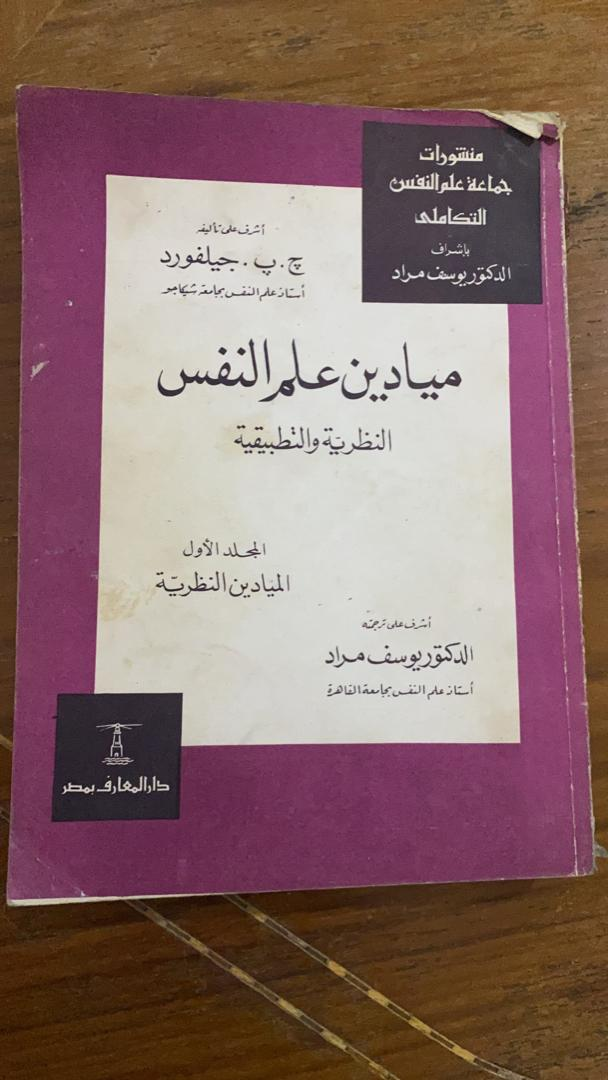

In [6]:
example = dataset["train"][0]
example["image"]

Take a look at the other information for this example.

In [7]:
words, boxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['ميادين علم النفس', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[[261, 313, 754, 373], [324, 204, 435, 218], [263, 226, 500, 255], [266, 261, 503, 279], [641, 245, 840, 266], [707, 225, 777, 239], [682, 191, 804, 212], [639, 161, 842, 185], [687, 135, 797, 155], [384, 393, 644, 423], [299, 500, 437, 517], [256, 528, 476, 552], [592, 571, 712, 585], [537, 594, 777, 621], [537, 629, 779, 649], [101, 717, 281, 738]]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [8]:
from transformers import AutoProcessor
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We'll first create `id2label` and label2id mappings, useful for inference. Note that `LayoutLMv3ForTokenClassification` (the model we'll use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [9]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [10]:
print(label_list)

['Title', 'Body text']


In [11]:
print(id2label)

{0: 'Title', 1: 'Body text'}


Next, we'll define a function which we can apply on the entire dataset.

In [39]:
import numpy as np
def prepare_examples(examples):
  images = examples[image_column_name] # if you use an image path, this will need to be updated to read the image in

  # Convert RGBA images to RGB
  for i, image in enumerate(images):
    if (image.mode != "RGB"):
      images[i] = image.convert("RGB")

  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [40]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

Next let's apply this to our train and eval datasets.

In [42]:
# I used this code to subset the data for building learning curves,
# you will probably ignore this and train on all the data
# train_sample = dataset["train"].shuffle(seed=42).select(range(300))

def lazy_map_function(batch):
    return prepare_examples(batch)

# Optimize the batch size and utilize parallelization
train_sample = dataset["train"]
train_dataset = train_sample.map(
    lazy_map_function,
    batched=True,
    remove_columns=column_names,
    features=features,
    batch_size=32,  # Adjust batch size as needed
    num_proc=4,     # Utilize multiple processes for parallel processing
    load_from_cache_file=False  # Load lazily from disk
)

# Optimize the batch size and utilize parallelization
eval_dataset = dataset["test"].map(
    lazy_map_function,
    batched=True,
    remove_columns=column_names,
    features=features,
    batch_size=32,  # Adjust batch size as needed
    num_proc=4,     # Utilize multiple processes for parallel processing
    load_from_cache_file=False  # Load lazily from disk
)

Map (num_proc=4):   0%|          | 0/672 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/84 [00:00<?, ? examples/s]

In [ ]:
# train_sample = dataset["train"]
# train_dataset = train_sample.map(
#     prepare_examples,
#     batched=True,
#     remove_columns=column_names,
#     features=features,
# )

# eval_dataset = dataset["test"].map(
#     prepare_examples,
#     batched=True,
#     remove_columns=column_names,
#     features=features,
# )

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

You can see the effect of the processing on the train dataset

In [43]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 672
})

Grab an example for helping some of the initial conditions

In [44]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> ميادين علم النفس</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

Next, we set the format to PyTorch.

In [45]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [46]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [47]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-47-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [48]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [49]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.
The training arguments I set here:
- max steps for how long I thought it would take to train - you may need more steps
- batch_size was tweaked based on GPU memory
- push to hub was set to save my model to the hugging face hub
- evaluation strategy, steps was set to periodically evaluate the model
- metric for best model was to save the best checkpoint model based on accuracy

In [50]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutlmv3-finetuned-arabic_books",
                                  max_steps=2500,
                                  per_device_train_batch_size=5,
                                  per_device_eval_batch_size=5,
                                  push_to_hub=True,  # after training, we'd like to push our model to the hub
                                  push_to_hub_model_id=f"layoutlmv3-finetuned-arabic_books",
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=250,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1984: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case alansary/layoutlmv3-finetuned-arabic_books).
  warnings.warn(


We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [51]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


## Train the model

Let's train!

In [52]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
250,No log,0.231845,0.962025,0.904762,0.932515,0.973262
500,0.088800,0.213916,0.962025,0.904762,0.932515,0.973262
750,0.088800,0.255884,0.962025,0.904762,0.932515,0.973262
1000,0.043300,0.257832,0.949367,0.892857,0.920245,0.967914
1250,0.043300,0.279014,0.962025,0.904762,0.932515,0.973262
1500,0.019600,0.287581,0.962025,0.904762,0.932515,0.973262
1750,0.019600,0.294622,0.962025,0.904762,0.932515,0.973262
2000,0.006800,0.304942,0.962025,0.904762,0.932515,0.973262
2250,0.006800,0.310078,0.962025,0.904762,0.932515,0.973262
2500,0.001500,0.311214,0.962025,0.904762,0.932515,0.973262


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Title seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Body text seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Title seems not to be NE tag.
  warnings.warn(

TrainOutput(global_step=2500, training_loss=0.03201494793891907, metrics={'train_runtime': 4842.6121, 'train_samples_per_second': 2.581, 'train_steps_per_second': 0.516, 'total_flos': 3280685091704832.0, 'train_loss': 0.03201494793891907, 'epoch': 18.51851851851852})

Let's push the final model to the hub

In [53]:
trainer.push_to_hub("layoutlmv3-finetuned-arabic_books")

CommitInfo(commit_url='https://huggingface.co/alansary/layoutlmv3-finetuned-arabic_books/commit/a61d78f5b87973c6ede58fb1e321bd903143be24', commit_message='layoutlmv3-finetuned-arabic_books', commit_description='', oid='a61d78f5b87973c6ede58fb1e321bd903143be24', pr_url=None, pr_revision=None, pr_num=None)

Evaluate the final model

In [54]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Title seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Body text seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.21391582489013672,
 'eval_precision': 0.9620253164556962,
 'eval_recall': 0.9047619047619048,
 'eval_f1': 0.9325153374233128,
 'eval_accuracy': 0.9732620320855615,
 'eval_runtime': 8.7321,
 'eval_samples_per_second': 9.62,
 'eval_steps_per_second': 1.947,
 'epoch': 18.51851851851852}

## Inference

This section loads the model from the hub and does not assume we have just trained the model. This is a realistic scenario for me, as Google Colab often makes me use multiple sessions.

In [55]:
from transformers import AutoModelForTokenClassification, AutoProcessor

model = AutoModelForTokenClassification.from_pretrained("alansary/layoutlmv3-finetuned-arabic_books")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Move the model to the GPU

In [56]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

Setup the preprocessing for the data and load one example for testing

In [57]:
# from transformers import LayoutLMv3Processor

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
example = dataset["test"][0]
image = example['image']
print(example.keys())

encoded_inputs = processor(example['image'], example['words'], boxes=example['bboxes'], word_labels=example['ner_tags'],
                           padding="max_length", truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image'])


NOTE: at "true inference" time, you don't have access to labels, see the end of this notebook how you can use `offset_mapping` in that case.

In [58]:
labels = encoded_inputs.pop('labels').squeeze().tolist()
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)

Get predictions

In [59]:
outputs = model(**encoded_inputs)
print(outputs.logits.shape)

torch.Size([1, 512, 2])


Convert the predictions into something useful for us

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [60]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

Set features

In [61]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

Get labels

In [62]:
# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

Get Predictions

In [63]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

true_predictions = [id2label[prediction] for prediction, label in zip(predictions, labels) if label != -100]
true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

Draws the predictions

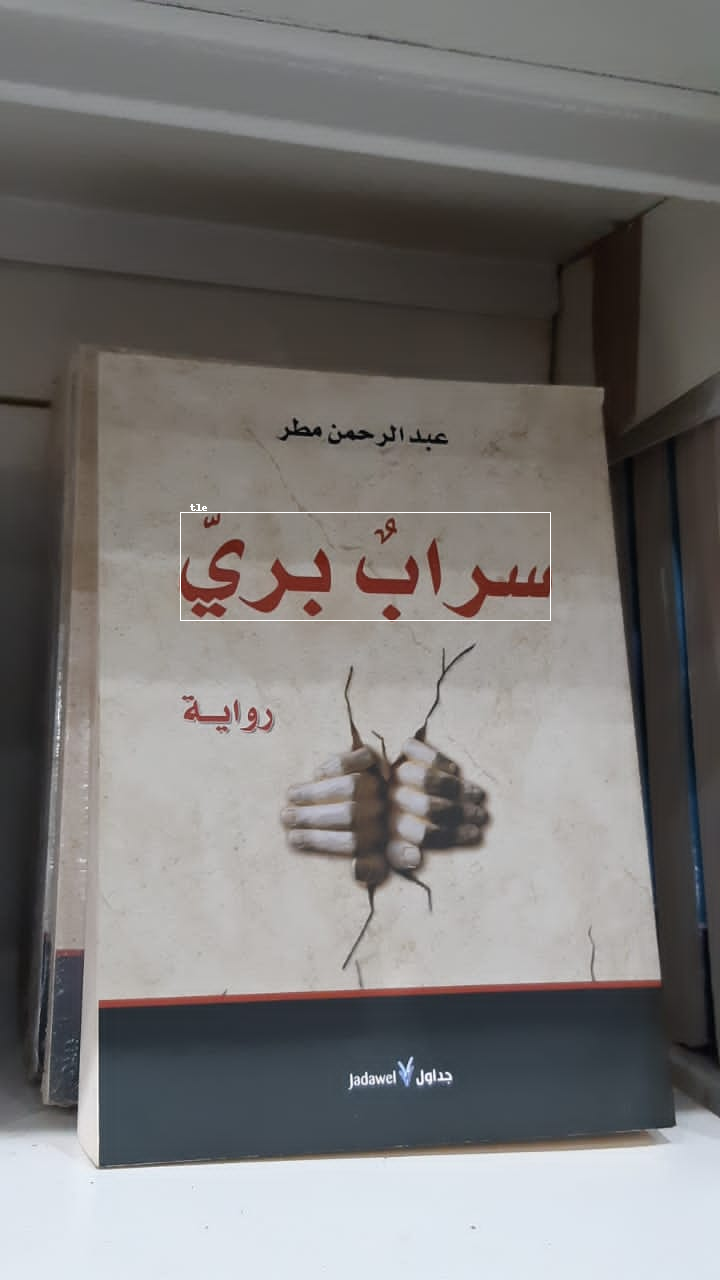

In [64]:
from PIL import ImageDraw
from PIL import Image, ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    #draw.rectangle(box, outline=label2color[predicted_label])
    draw.rectangle(box)
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, font=font)
    #draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

## Batch inference

Preprocess the data

In [65]:
def prepare_examples(examples):
  images = examples[image_column_name] # if you use an image path, this will need to be updated to read the image in

  # Convert RGBA images to RGB
  for i, image in enumerate(images):
    if (image.mode != "RGB"):
      images[i] = image.convert("RGB")

  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding


Features

In [66]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

Metrics for Evaluation

In [67]:
# Metrics
from datasets import load_metric
import numpy as np

metric = load_metric("seqeval")
return_entity_level_metrics = True


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Preprocess dataset

In [68]:
def lazy_map_function(batch):
    return prepare_examples(batch)

# Optimize the batch size and utilize parallelization
val_dataset = dataset['validation'].map(
    lazy_map_function,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    features=features,
    batch_size=32,  # Adjust batch size as needed
    num_proc=4,     # Utilize multiple processes for parallel processing
    load_from_cache_file=False  # Load lazily from disk
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/84 [00:00<?, ? examples/s]

In [69]:
# val_dataset = dataset['validation'].map(prepare_examples,
#                                       batched=True,
#                                       remove_columns=dataset['validation'].column_names,
#                                       features=features)

Use the Trainer for batch inference
- adjust the batch size to what works for your setup

In [70]:
from transformers import TrainingArguments, Trainer

test_args = TrainingArguments(
    output_dir = "layoutlmv3-finetuned-arabic-books",
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = 5,
    dataloader_drop_last = False
)

# init trainer
trainer = Trainer(
              model = model,
              args = test_args,
              compute_metrics = compute_metrics)

In [71]:
#predictionsT, labelsT, metricsT = trainer.predict(eval_dataset)
predictionsV, labelsV, metricsV = trainer.predict(val_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1052: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Title seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Body text seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
metricsV

{'test_loss': 0.03870440274477005,
 'test_itle_precision': 0.987012987012987,
 'test_itle_recall': 0.987012987012987,
 'test_itle_f1': 0.987012987012987,
 'test_itle_number': 77,
 'test_ody text_precision': 0.0,
 'test_ody text_recall': 0.0,
 'test_ody text_f1': 0.0,
 'test_ody text_number': 2,
 'test_overall_precision': 0.987012987012987,
 'test_overall_recall': 0.9620253164556962,
 'test_overall_f1': 0.9743589743589742,
 'test_overall_accuracy': 0.9875776397515528,
 'test_runtime': 8.8751,
 'test_samples_per_second': 9.465,
 'test_steps_per_second': 1.915}

## Note: inference when you don't have labels

The code above used the `labels` to determine which tokens were at the start of a particular word or not. Of course, at inference time, you don't have access to any labels. In that case, you can leverage the `offset_mapping` returned by the tokenizer.